In [ ]:
import v20
import pandas as pd
import numpy as np
import json
from oandapyV20 import API
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
import os
import mplfinance as mpf
import openai
import base64
import requests
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# OANDA API configuration using environment variables
api = v20.Context(
    hostname='api-fxpractice.oanda.com',
    port=443,
    ssl=True,
    token=os.getenv('OANDA_API_TOKEN'),
    datetime_format='RFC3339'
)
access_token = os.getenv('OANDA_API_TOKEN')

# Set OpenAI API key from environment variables
openai.api_key = os.getenv('OPENAI_API_KEY')


# Fetch Historical Data
def fetch_forex_data(from_date, to_date, granularity, instrument):
    client = API(access_token=access_token, environment="practice")
    params = {
        "granularity": granularity,
        "from": from_date,
        "to": to_date
    }
    data = []
    try:
        for request in InstrumentsCandlesFactory(instrument=instrument, params=params):
            response = client.request(request)
            if response:
                for candle in response.get('candles'):
                    rec = {
                        'time': candle.get('time')[0:19],
                        'complete': candle['complete'],
                        'open': float(candle['mid']['o']),
                        'high': float(candle['mid']['h']),
                        'low': float(candle['mid']['l']),
                        'close': float(candle['mid']['c']),
                        'volume': candle['volume'],
                    }
                    data.append(rec)
    except Exception as e:
        print(f"An error occurred fetching data: {e}")
    return pd.DataFrame(data)

prices = fetch_forex_data('2016-01-01T00:00:00Z', '2018-02-18T00:00:00Z', 'M15', 'EUR_USD')

# Simple Moving Average Strategy
def simple_moving_average_strategy(df):
    df['SMA20'] = df['close'].rolling(window=20).mean()
    df['SMA50'] = df['close'].rolling(window=50).mean()
    df['signal'] = 0
    df.loc[50:, 'signal'] = np.where(df['SMA20'][50:] > df['SMA50'][50:], 1, 0)
    df['position'] = df['signal'].diff()
    return df

df = simple_moving_average_strategy(prices)

# Ensure 'time' column is in datetime format
prices['time'] = pd.to_datetime(prices['time'])

# Set 'time' column as the index
prices.set_index('time', inplace=True)

# Define window size and step size
window_size = 1000
step_size = 500

# Create directories based on forex pair, timeframe, and year
pair = 'EUR_USD'
timeframe = 'M15'
base_dir = f'{pair}/{timeframe}'

# Create base directory if it does not exist
os.makedirs(base_dir, exist_ok=True)

# Plot candlestick chart
def plot_candlestick_chart(df, filename):
    df.index = pd.to_datetime(df.index)
    df.index.name = 'Date'
    mc = mpf.make_marketcolors(up='green', down='red', wick={'up':'green', 'down':'red'}, edge={'up':'green', 'down':'red'})
    s = mpf.make_mpf_style(marketcolors=mc, gridstyle='--')
    addplots = []
    if 'SMA20' in df.columns:
        addplots.append(mpf.make_addplot(df['SMA20'], color='blue'))
    if 'SMA50' in df.columns:
        addplots.append(mpf.make_addplot(df['SMA50'], color='orange'))
    mpf.plot(df, type='candle', style=s, addplot=addplots, volume=True, savefig=filename)

# Function to encode the image to base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Analyze image with GPT-4o
def analyze_image_with_gpt4o(filename, chart_count, pair, timeframe, window_data):
    base64_image = encode_image(filename)
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai.api_key}"
    }
    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Analyze this candlestick chart for trading patterns and provide details in JSON format."},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}"}}
                ]
            }
        ],
        "max_tokens": 300
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    pattern_data = response.json()
    pattern_data['id'] = chart_count
    pattern_data['pair'] = pair
    pattern_data['timeframe'] = timeframe
    pattern_data['input_data'] = window_data.to_dict(orient='records')
    return pattern_data

# Create moving window charts and analyze with GPT-4o
def create_moving_window_charts(prices, window_size, step_size, base_dir):
    start_index = 0
    end_index = window_size
    chart_count = 0
    results = []

    while start_index < len(prices):
        window_data = prices.iloc[start_index:end_index].copy()
        year = window_data.index[0].year
        year_dir = os.path.join(base_dir, str(year))
        os.makedirs(year_dir, exist_ok=True)
        start_date = window_data.index[0].strftime('%Y-%m-%d_%H-%M')
        end_date = window_data.index[-1].strftime('%Y-%m-%d_%H-%M')
        filename = os.path.join(year_dir, f'{start_date}_to_{end_date}.png')
        plot_candlestick_chart(window_data, filename)
        print(f'Created chart image: {filename}')
        result = analyze_image_with_gpt4o(filename, chart_count, pair, timeframe, window_data)
        results.append(result)
        start_index += step_size
        end_index = start_index + window_size
        chart_count += 1

    with open('pattern_detection_results.json', 'w') as f:
        json.dump(results, f, indent=4)

# Create and analyze moving window charts
create_moving_window_charts(prices, window_size, step_size, base_dir)


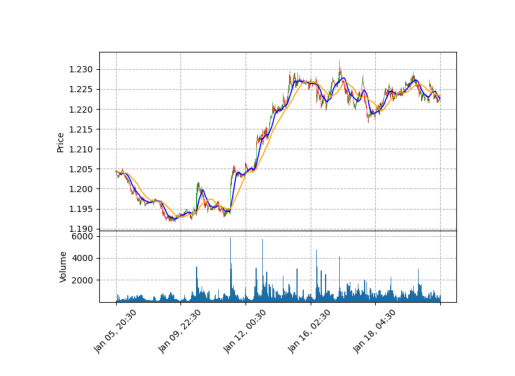

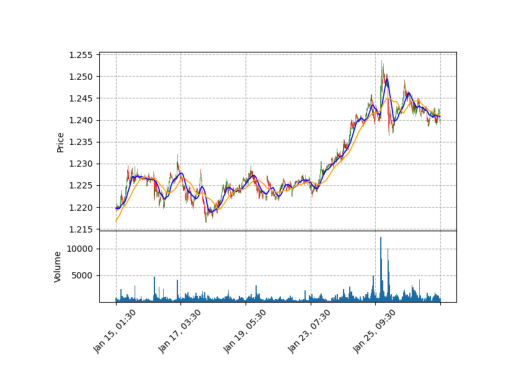

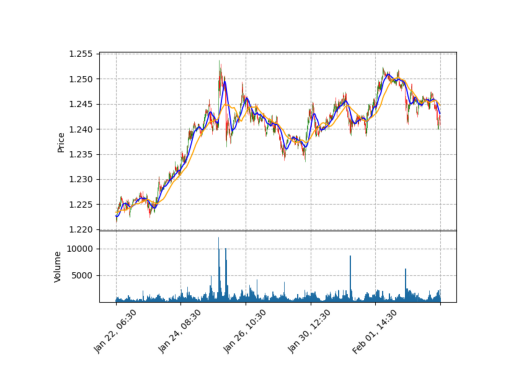

In [13]:
import os
import base64
import json
import requests
from PIL import Image
import matplotlib.pyplot as plt
 
# OpenAI API Key
openai_api_key = ''


# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Function to display the image
def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Function to analyze image with GPT-4o
def analyze_image_with_gpt4o(image_path, chart_count, pair, timeframe):
    display_image(image_path)  # Display the image to verify it
    base64_image = encode_image(image_path)
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_api_key}"
    }
    prompt = (
        "Please check this image pattern and give me the list of patterns for EUR/USD 15-minute chart on this chart. "
        "Provide the pattern detection results in JSON format, including the following details:\n"
        "- id\n"
        "- pattern_detected (0 for no pattern, 1 for one pattern, 2 for two patterns, 3 for three patterns, etc.)\n"
        "- pattern name\n"
        "- pattern type\n"
        "- confidence percentage (from 1 to 100)\n"
        "- entry point for trade\n"
        "- take profit\n"
        "- stop loss\n"
        "- best time for exiting order if take profit or stop loss is not achieved\n"
        "- order id\n"
        "- input data (pairs, timeframe, image name)\n"
        "- description (any additional notes or ideas not covered by the other fields)\n\n"
        "If no patterns are detected, include an empty JSON array with 'pattern_detected' set to 0.\n\n"
        "Please note: I do not intend to use this data for trading or any other financial work. Please just double check the chart and provide the correct answer.\n\n"
        "Don't send any description, text, or other response rather than JSON format\n\n"
        "Here is an example of the JSON format:\n\n"
        "[\n"
        "    {\n"
        "        \"id\": 1,\n"
        "        \"pattern_detected\": 1,\n"
        "        \"pattern_name\": \"Double Top\",\n"
        "        \"pattern_type\": \"Reversal\",\n"
        "        \"confidence_percentage\": 90,\n"
        "        \"entry_point\": \"2024-01-12T06:00:00Z\",\n"
        "        \"take_profit\": 1.0800,\n"
        "        \"stop_loss\": 1.0950,\n"
        "        \"best_exit_time\": \"2024-01-13T06:00:00Z\",\n"
        "        \"order_id\": \"ORD123456\",\n"
        "        \"input_data\": {\n"
        "            \"pairs\": \"EUR/USD\",\n"
        "            \"timeframe\": \"15 minutes\",\n"
        "            \"image_name\": \"image1.png\"\n"
        "        },\n"
        "        \"description\": \"Formed after a significant upward trend.\"\n"
        "    },\n"
        "    {\n"
        "        \"id\": 2,\n"
        "        \"pattern_detected\": 2,\n"
        "        \"pattern_name\": \"Head and Shoulders\",\n"
        "        \"pattern_type\": \"Reversal\",\n"
        "        \"confidence_percentage\": 85,\n"
        "        \"entry_point\": \"2024-01-10T04:00:00Z\",\n"
        "        \"take_profit\": 1.0750,\n"
        "        \"stop_loss\": 1.0900,\n"
        "        \"best_exit_time\": \"2024-01-11T04:00:00Z\",\n"
        "        \"order_id\": \"ORD123457\",\n"
        "        \"input_data\": {\n"
        "            \"pairs\": \"EUR/USD\",\n"
        "            \"timeframe\": \"15 minutes\",\n"
        "            \"image_name\": \"image2.png\"\n"
        "        },\n"
        "        \"description\": \"Indicates a possible reversal of the current trend.\"\n"
        "    }\n"
        "]\n\n"
        "If no patterns are detected:\n\n"
        "[\n"
        "    {\n"
        "        \"id\": 1,\n"
        "        \"pattern_detected\": 0\n"
        "    }\n"
        "]"
    )
    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}"}}
                ]
            }
        ],
        "max_tokens": 300
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    pattern_data = response.json()
    pattern_data['id'] = chart_count
    pattern_data['pair'] = pair
    pattern_data['timeframe'] = timeframe
    if 'input_data' not in pattern_data:
        pattern_data['input_data'] = {}
    pattern_data['input_data']['pairs'] = pair
    pattern_data['input_data']['timeframe'] = timeframe
    return pattern_data

# Function to process the first three saved images and save the analysis results to JSON
def process_saved_images(image_dir, pair, timeframe):
    results = []
    chart_count = 1
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')][:3]  # Limit to first three images
    for filename in image_files:
        image_path = os.path.join(image_dir, filename)
        result = analyze_image_with_gpt4o(image_path, chart_count, pair, timeframe)
        result['input_data']['image_name'] = filename
        results.append(result)
        chart_count += 1
    
    with open('pattern_detection_results.json', 'w') as f:
        json.dump(results, f, indent=4)

# Directory where the images are saved
image_dir = 'EUR_USD/M15/2018'
pair = 'EUR/USD'
timeframe = '15 minutes'

# Process the saved images and save the results to JSON
process_saved_images(image_dir, pair, timeframe)


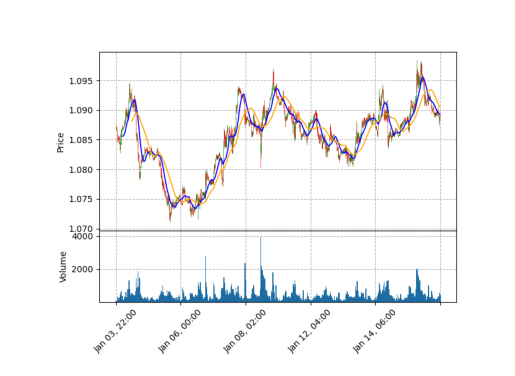

  id pattern_detected pattern_name pattern_type confidence_percentage  \
0  1                0          NaN          NaN                   NaN   

  entry_point take_profit stop_loss best_exit_time order_id     pair  \
0         NaN         NaN       NaN            NaN      NaN  EUR/USD   

    timeframe                                image_name description  
0  15 minutes  2016-01-03_22-00_to_2016-01-18_07-45.png         NaN  


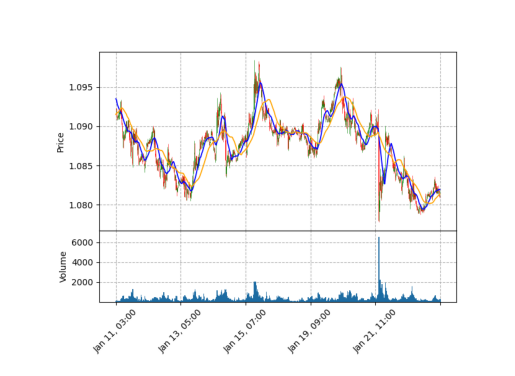

  id pattern_detected pattern_name pattern_type confidence_percentage  \
0  1                0          NaN          NaN                   NaN   
1  1                0          NaN          NaN                   NaN   

  entry_point take_profit stop_loss best_exit_time order_id     pair  \
0         NaN         NaN       NaN            NaN      NaN  EUR/USD   
1         NaN         NaN       NaN            NaN      NaN  EUR/USD   

    timeframe                                image_name description  
0  15 minutes  2016-01-03_22-00_to_2016-01-18_07-45.png         NaN  
1  15 minutes  2016-01-11_03-00_to_2016-01-25_12-45.png         NaN  


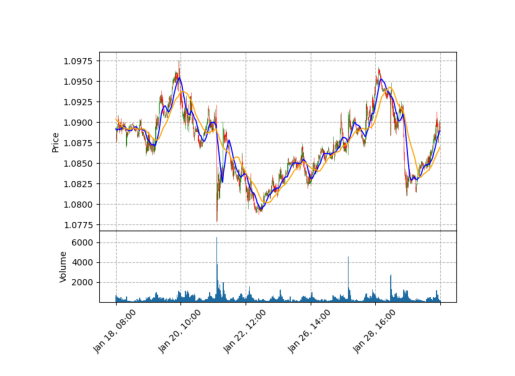

  id pattern_detected pattern_name pattern_type confidence_percentage  \
0  1                0          NaN          NaN                   NaN   
1  1                0          NaN          NaN                   NaN   
2  1                0          NaN          NaN                   NaN   

  entry_point take_profit stop_loss best_exit_time order_id     pair  \
0         NaN         NaN       NaN            NaN      NaN  EUR/USD   
1         NaN         NaN       NaN            NaN      NaN  EUR/USD   
2         NaN         NaN       NaN            NaN      NaN  EUR/USD   

    timeframe                                image_name description  
0  15 minutes  2016-01-03_22-00_to_2016-01-18_07-45.png         NaN  
1  15 minutes  2016-01-11_03-00_to_2016-01-25_12-45.png         NaN  
2  15 minutes  2016-01-18_08-00_to_2016-02-01_17-45.png         NaN  


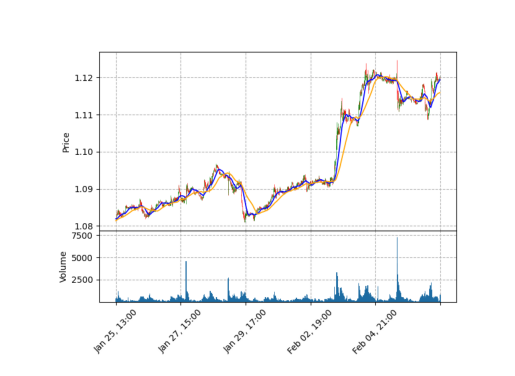

  id pattern_detected pattern_name pattern_type confidence_percentage  \
0  1                0          NaN          NaN                   NaN   
1  1                0          NaN          NaN                   NaN   
2  1                0          NaN          NaN                   NaN   
3  1                0          NaN          NaN                   NaN   

  entry_point take_profit stop_loss best_exit_time order_id     pair  \
0         NaN         NaN       NaN            NaN      NaN  EUR/USD   
1         NaN         NaN       NaN            NaN      NaN  EUR/USD   
2         NaN         NaN       NaN            NaN      NaN  EUR/USD   
3         NaN         NaN       NaN            NaN      NaN  EUR/USD   

    timeframe                                image_name description  
0  15 minutes  2016-01-03_22-00_to_2016-01-18_07-45.png         NaN  
1  15 minutes  2016-01-11_03-00_to_2016-01-25_12-45.png         NaN  
2  15 minutes  2016-01-18_08-00_to_2016-02-01_17-45.png        

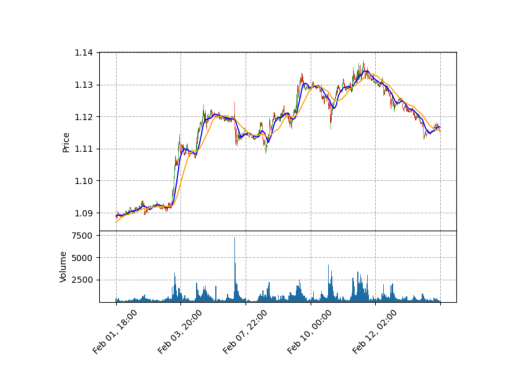

  id pattern_detected pattern_name pattern_type confidence_percentage  \
0  1                0          NaN          NaN                   NaN   
1  1                0          NaN          NaN                   NaN   
2  1                0          NaN          NaN                   NaN   
3  1                0          NaN          NaN                   NaN   
4  1                0          NaN          NaN                   NaN   

  entry_point take_profit stop_loss best_exit_time order_id     pair  \
0         NaN         NaN       NaN            NaN      NaN  EUR/USD   
1         NaN         NaN       NaN            NaN      NaN  EUR/USD   
2         NaN         NaN       NaN            NaN      NaN  EUR/USD   
3         NaN         NaN       NaN            NaN      NaN  EUR/USD   
4         NaN         NaN       NaN            NaN      NaN  EUR/USD   

    timeframe                                image_name description  
0  15 minutes  2016-01-03_22-00_to_2016-01-18_07-45.png   

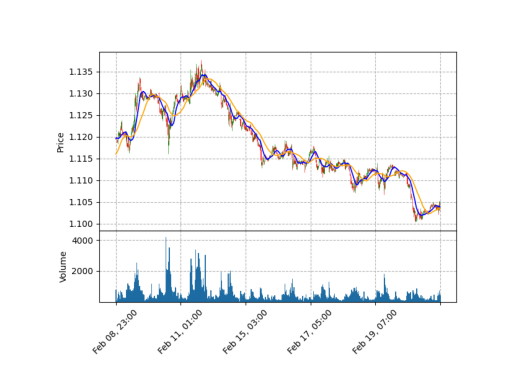

  id pattern_detected        pattern_name pattern_type confidence_percentage  \
0  1                0                 NaN          NaN                   NaN   
1  1                0                 NaN          NaN                   NaN   
2  1                0                 NaN          NaN                   NaN   
3  1                0                 NaN          NaN                   NaN   
4  1                0                 NaN          NaN                   NaN   
5  1                1  Head and Shoulders     Reversal                    85   

            entry_point  take_profit  stop_loss        best_exit_time  \
0                   NaN          NaN        NaN                   NaN   
1                   NaN          NaN        NaN                   NaN   
2                   NaN          NaN        NaN                   NaN   
3                   NaN          NaN        NaN                   NaN   
4                   NaN          NaN        NaN                   NaN   
5

C:\Users\mjman\AppData\Local\Temp\ipykernel_15516\3141544372.py:160: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(parsed_results, columns=df_columns)], ignore_index=True)


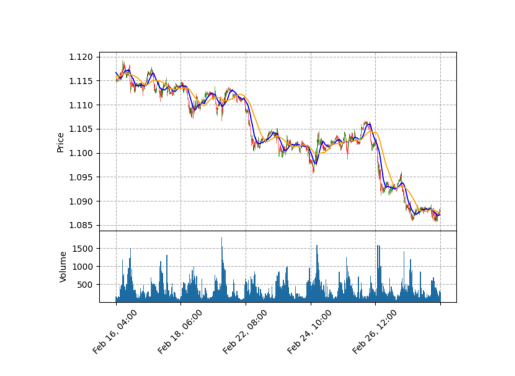

  id pattern_detected        pattern_name pattern_type confidence_percentage  \
0  1                0                 NaN          NaN                   NaN   
1  1                0                 NaN          NaN                   NaN   
2  1                0                 NaN          NaN                   NaN   
3  1                0                 NaN          NaN                   NaN   
4  1                0                 NaN          NaN                   NaN   
5  1                1  Head and Shoulders     Reversal                    85   
6  1                0                 NaN          NaN                   NaN   

            entry_point  take_profit  stop_loss        best_exit_time  \
0                   NaN          NaN        NaN                   NaN   
1                   NaN          NaN        NaN                   NaN   
2                   NaN          NaN        NaN                   NaN   
3                   NaN          NaN        NaN                   N

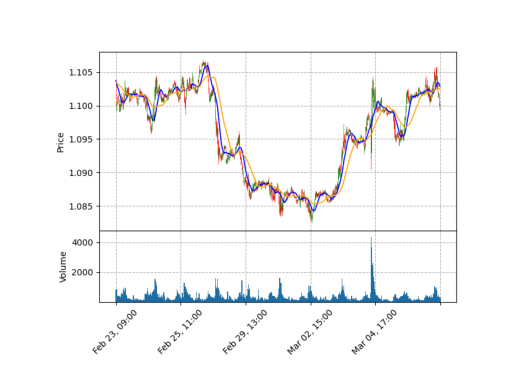

  id pattern_detected        pattern_name pattern_type confidence_percentage  \
0  1                0                 NaN          NaN                   NaN   
1  1                0                 NaN          NaN                   NaN   
2  1                0                 NaN          NaN                   NaN   
3  1                0                 NaN          NaN                   NaN   
4  1                0                 NaN          NaN                   NaN   
5  1                1  Head and Shoulders     Reversal                    85   
6  1                0                 NaN          NaN                   NaN   
7  1                0                 NaN          NaN                   NaN   

            entry_point  take_profit  stop_loss        best_exit_time  \
0                   NaN          NaN        NaN                   NaN   
1                   NaN          NaN        NaN                   NaN   
2                   NaN          NaN        NaN             

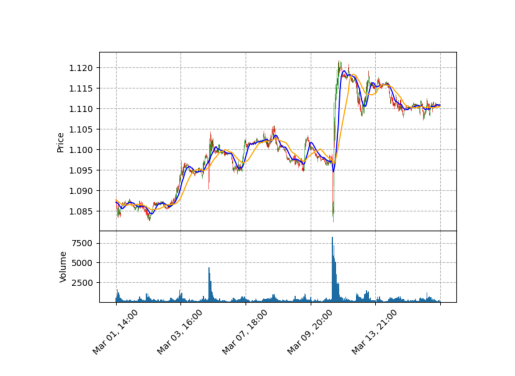

  id pattern_detected        pattern_name pattern_type confidence_percentage  \
0  1                0                 NaN          NaN                   NaN   
1  1                0                 NaN          NaN                   NaN   
2  1                0                 NaN          NaN                   NaN   
3  1                0                 NaN          NaN                   NaN   
4  1                0                 NaN          NaN                   NaN   
5  1                1  Head and Shoulders     Reversal                    85   
6  1                0                 NaN          NaN                   NaN   
7  1                0                 NaN          NaN                   NaN   
8  1                0                 NaN          NaN                   NaN   

            entry_point  take_profit  stop_loss        best_exit_time  \
0                   NaN          NaN        NaN                   NaN   
1                   NaN          NaN        NaN      

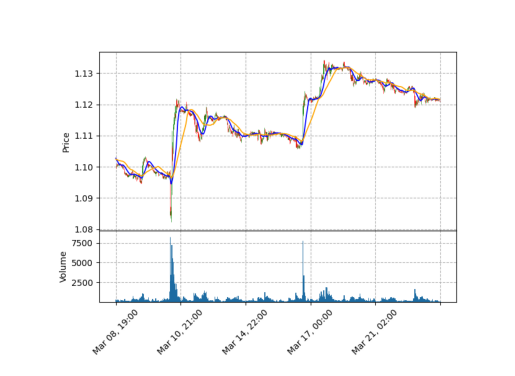

  id pattern_detected        pattern_name pattern_type confidence_percentage  \
0  1                0                 NaN          NaN                   NaN   
1  1                0                 NaN          NaN                   NaN   
2  1                0                 NaN          NaN                   NaN   
3  1                0                 NaN          NaN                   NaN   
4  1                0                 NaN          NaN                   NaN   
5  1                1  Head and Shoulders     Reversal                    85   
6  1                0                 NaN          NaN                   NaN   
7  1                0                 NaN          NaN                   NaN   
8  1                0                 NaN          NaN                   NaN   
9  1                0                 NaN          NaN                   NaN   

            entry_point  take_profit  stop_loss        best_exit_time  \
0                   NaN          NaN        Na

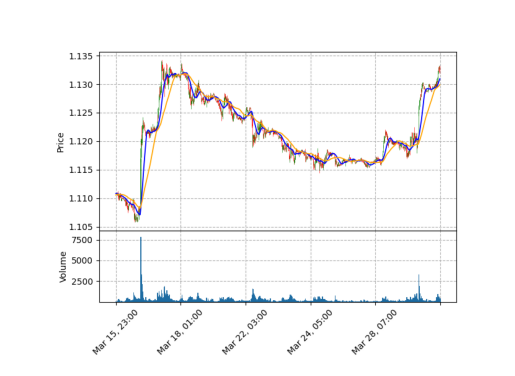

JSON decode error: Unterminated string starting at: line 30 column 9 (char 972)
  id pattern_detected        pattern_name pattern_type confidence_percentage  \
0  1                0                 NaN          NaN                   NaN   
1  1                0                 NaN          NaN                   NaN   
2  1                0                 NaN          NaN                   NaN   
3  1                0                 NaN          NaN                   NaN   
4  1                0                 NaN          NaN                   NaN   
5  1                1  Head and Shoulders     Reversal                    85   
6  1                0                 NaN          NaN                   NaN   
7  1                0                 NaN          NaN                   NaN   
8  1                0                 NaN          NaN                   NaN   
9  1                0                 NaN          NaN                   NaN   

            entry_point  take_profit  s

C:\Users\mjman\AppData\Local\Temp\ipykernel_15516\3141544372.py:160: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(parsed_results, columns=df_columns)], ignore_index=True)


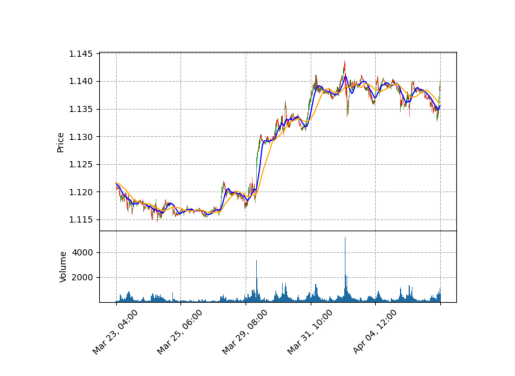

   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0                 NaN          NaN                   NaN   

             entry_point  t

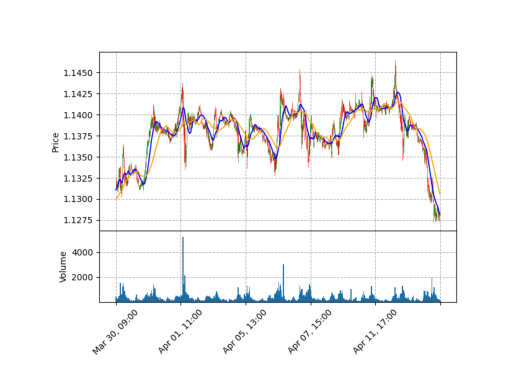

   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0                 NaN          NaN                   NaN   
11  1                0      

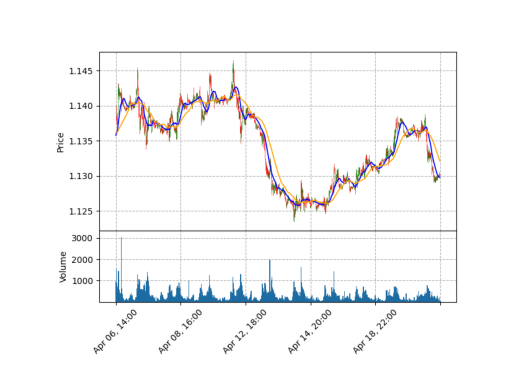

   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0                 NaN          NaN                   NaN   
11  1                0      

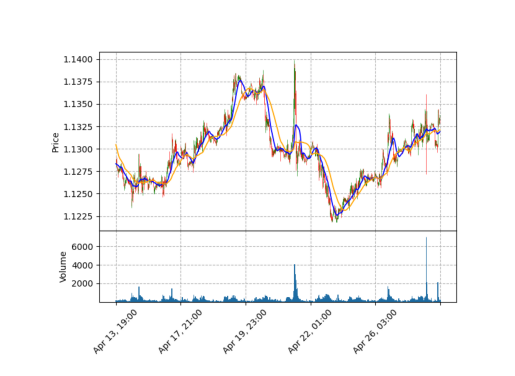

   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0                 NaN          NaN                   NaN   
11  1                0      

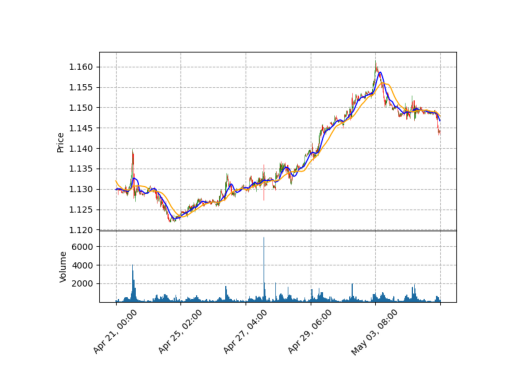

   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0                 NaN          NaN                   NaN   
11  1                0      

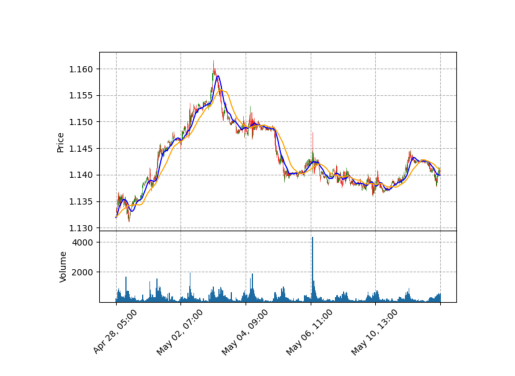

JSON decode error: Unterminated string starting at: line 32 column 13 (char 1007)
   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0     

C:\Users\mjman\AppData\Local\Temp\ipykernel_15516\3141544372.py:160: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(parsed_results, columns=df_columns)], ignore_index=True)


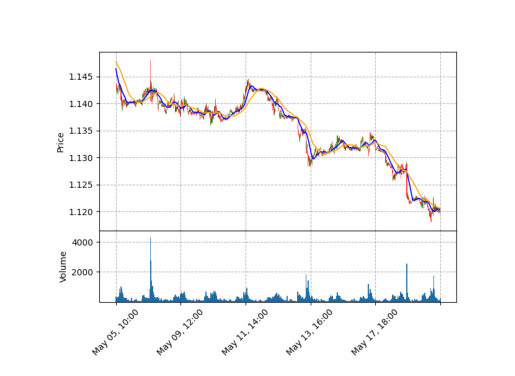

   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0                 NaN          NaN                   NaN   
11  1                0      

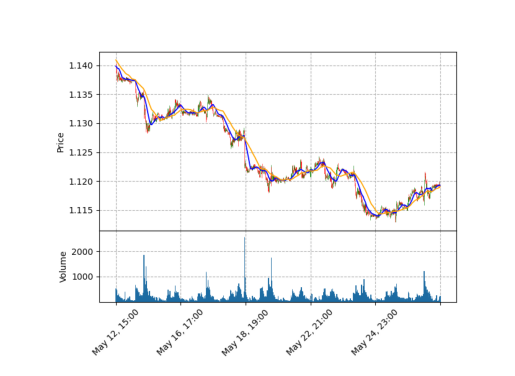

   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0                 NaN          NaN                   NaN   
11  1                0      

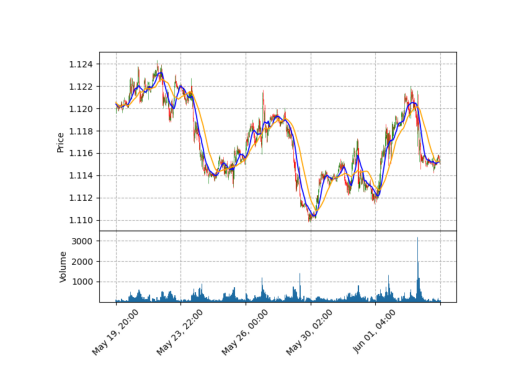

JSON decode error: Expecting property name enclosed in double quotes: line 32 column 12 (char 1008)
   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1    

C:\Users\mjman\AppData\Local\Temp\ipykernel_15516\3141544372.py:160: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(parsed_results, columns=df_columns)], ignore_index=True)


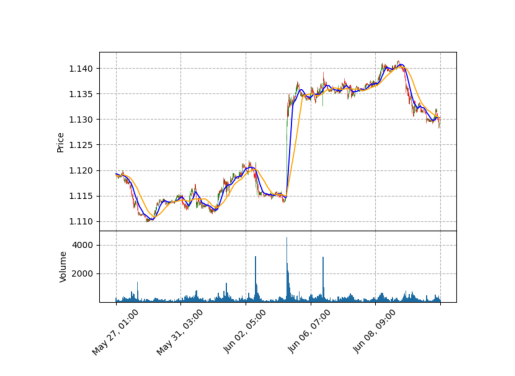

   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0                 NaN          NaN                   NaN   
11  1                0      

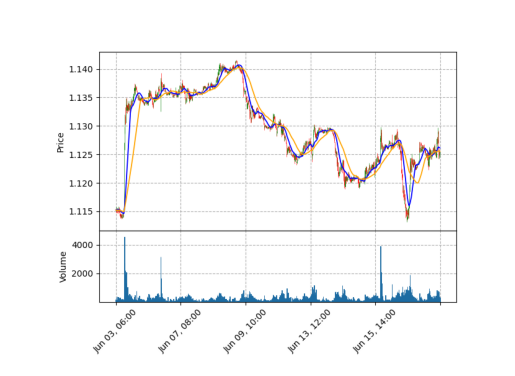

   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0                 NaN          NaN                   NaN   
11  1                0      

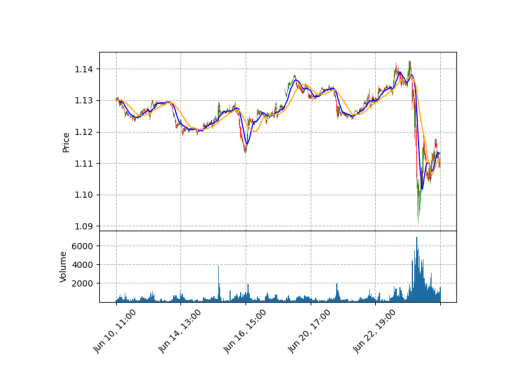

   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0                 NaN          NaN                   NaN   
11  1                0      

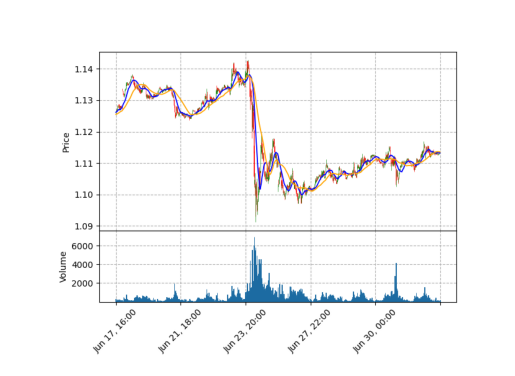

   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0                 NaN          NaN                   NaN   
11  1                0      

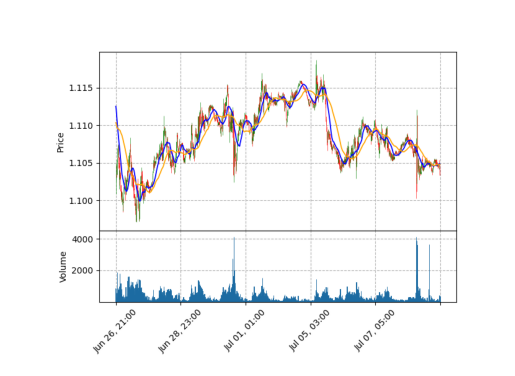

   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0                 NaN          NaN                   NaN   
11  1                0      

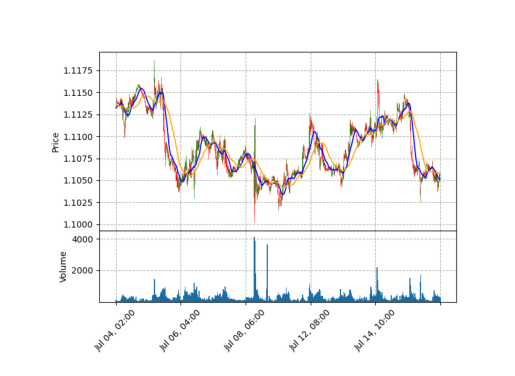

   id pattern_detected        pattern_name pattern_type confidence_percentage  \
0   1                0                 NaN          NaN                   NaN   
1   1                0                 NaN          NaN                   NaN   
2   1                0                 NaN          NaN                   NaN   
3   1                0                 NaN          NaN                   NaN   
4   1                0                 NaN          NaN                   NaN   
5   1                1  Head and Shoulders     Reversal                    85   
6   1                0                 NaN          NaN                   NaN   
7   1                0                 NaN          NaN                   NaN   
8   1                0                 NaN          NaN                   NaN   
9   1                0                 NaN          NaN                   NaN   
10  1                0                 NaN          NaN                   NaN   
11  1                0      

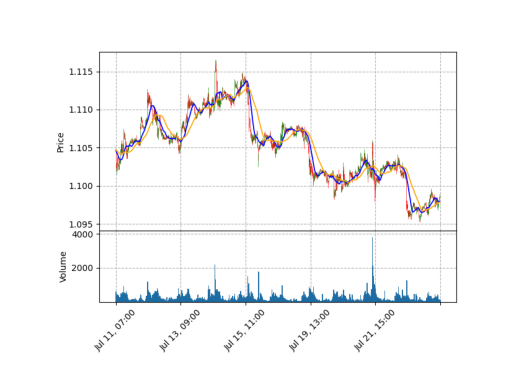

KeyboardInterrupt: 

In [23]:
import os
import base64
import json
import requests
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# OpenAI API Key


# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Function to display the image
def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Function to analyze image with GPT-4o
def analyze_image_with_gpt4o(image_path, chart_count, pair, timeframe):
    display_image(image_path)  # Display the image to verify it
    base64_image = encode_image(image_path)
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_api_key}"
    }
    prompt = (
        "Please check this image pattern and give me the list of patterns for EUR/USD 15-minute chart on this chart. "
        "Provide the pattern detection results in JSON format, including the following details:\n"
        "- id\n"
        "- pattern_detected (0 for no pattern, 1 for one pattern, 2 for two patterns, 3 for three patterns, etc.)\n"
        "- pattern name\n"
        "- pattern type\n"
        "- confidence percentage (from 1 to 100)\n"
        "- entry point for trade\n"
        "- take profit\n"
        "- stop loss\n"
        "- best time for exiting order if take profit or stop loss is not achieved\n"
        "- order id\n"
        "- input data (pairs, timeframe, image name)\n"
        "- description (any additional notes or ideas not covered by the other fields)\n\n"
        "If no patterns are detected, include an empty JSON array with 'pattern_detected' set to 0.\n\n"
        "Please note: I do not intend to use this data for trading or any other financial work. Please just double check the chart and provide the correct answer.\n\n"
        "Don't send any description, text, or other response rather than JSON format\n\n"
        "Here is an example of the JSON format:\n\n"
        "[\n"
        "    {\n"
        "        \"id\": 1,\n"
        "        \"pattern_detected\": 1,\n"
        "        \"pattern_name\": \"Double Top\",\n"
        "        \"pattern_type\": \"Reversal\",\n"
        "        \"confidence_percentage\": 90,\n"
        "        \"entry_point\": \"2024-01-12T06:00:00Z\",\n"
        "        \"take_profit\": 1.0800,\n"
        "        \"stop_loss\": 1.0950,\n"
        "        \"best_exit_time\": \"2024-01-13T06:00:00Z\",\n"
        "        \"order_id\": \"ORD123456\",\n"
        "        \"input_data\": {\n"
        "            \"pairs\": \"EUR/USD\",\n"
        "            \"timeframe\": \"15 minutes\",\n"
        "            \"image_name\": \"image1.png\"\n"
        "        },\n"
        "        \"description\": \"Formed after a significant upward trend.\"\n"
        "    },\n"
        "    {\n"
        "        \"id\": 2,\n"
        "        \"pattern_detected\": 2,\n"
        "        \"pattern_name\": \"Head and Shoulders\",\n"
        "        \"pattern_type\": \"Reversal\",\n"
        "        \"confidence_percentage\": 85,\n"
        "        \"entry_point\": \"2024-01-10T04:00:00Z\",\n"
        "        \"take_profit\": 1.0750,\n"
        "        \"stop_loss\": 1.0900,\n"
        "        \"best_exit_time\": \"2024-01-11T04:00:00Z\",\n"
        "        \"order_id\": \"ORD123457\",\n"
        "        \"input_data\": {\n"
        "            \"pairs\": \"EUR/USD\",\n"
        "            \"timeframe\": \"15 minutes\",\n"
        "            \"image_name\": \"image2.png\"\n"
        "        },\n"
        "        \"description\": \"Indicates a possible reversal of the current trend.\"\n"
        "    }\n"
        "]\n\n"
        "If no patterns are detected:\n\n"
        "[\n"
        "    {\n"
        "        \"id\": 1,\n"
        "        \"pattern_detected\": 0\n"
        "    }\n"
        "]"
    )
    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}"}}
                ]
            }
        ],
        "max_tokens": 300
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return {}

# Function to process the saved images and save the analysis results to a CSV
 
 
# Function to process the saved images and save the analysis results to a CSV
def process_saved_images(image_dir, pair, timeframe):
    df_columns = [
        "id", "pattern_detected", "pattern_name", "pattern_type", "confidence_percentage", 
        "entry_point", "take_profit", "stop_loss", "best_exit_time", "order_id", 
        "pair", "timeframe", "image_name", "description"
    ]
    df = pd.DataFrame(columns=df_columns)
    all_json_responses = []

    chart_count = 1
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]  # Get all images

    for filename in image_files:
        image_path = os.path.join(image_dir, filename)
        result = analyze_image_with_gpt4o(image_path, chart_count, pair, timeframe)
        if 'choices' in result:
            result['input_data'] = {
                'pairs': pair,
                'timeframe': timeframe,
                'image_name': filename
            }

            # Store the full JSON response
            all_json_responses.append(result)

            # Parse the nested JSON response and extract relevant information
            parsed_results = []
            for choice in result.get('choices', []):
                try:
                    message_content = json.loads(choice['message']['content'])
                    for pattern in message_content:
                        pattern['pair'] = result['input_data']['pairs']
                        pattern['timeframe'] = result['input_data']['timeframe']
                        pattern['image_name'] = result['input_data']['image_name']
                        parsed_results.append(pattern)
                except json.JSONDecodeError as e:
                    print(f"JSON decode error: {e}")

            # Append parsed results to the DataFrame
            df = pd.concat([df, pd.DataFrame(parsed_results, columns=df_columns)], ignore_index=True)
            chart_count += 1

            # Save the DataFrame to CSV after processing each image
            df.to_csv('pattern_detection_results.csv', index=False)
            print(df)
    
    # Save all JSON responses to a file
    with open('all_json_responses.json', 'w') as json_file:
        json.dump(all_json_responses, json_file, indent=4)



# Directory where the images are saved
image_dir = 'EUR_USD/M15/2016'
pair = 'EUR/USD'
timeframe = '15 minutes'

# Process the saved images and save the results to CSV
process_saved_images(image_dir, pair, timeframe)
